<a href="https://colab.research.google.com/github/sebasruggero/analisis_transporte_catamarca/blob/main/An%C3%A1lisis_Catamarca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![img](https://www.argentina.gob.ar/sites/default/files/min_transporte.png)
# Análisis de Transacciones SUBE Ciudad San Fernando del Valle de Catamarca
## Subsecretaria de Proyectos Estratégicos y Desarrollo Tecnológico

[Visualizacion PowerBi](https://app.powerbi.com/view?r=eyJrIjoiNzhiNGI3ZTAtZjBiMS00ZGU4LWE0ODctZDRkNjNhMTIxYzkzIiwidCI6IjI4MzQzN2IwLWFhNWMtNGMyZi05NjZjLWRmNDA5ZjdhMWM4ZSIsImMiOjR9&pageName=ReportSection2514b0e19aba8989a290)     

<img src="https://cdn-dhhph.nitrocdn.com/YwrWfrMMnPrQoiMcCnngShsqFHLItupA/assets/static/optimized/rev-c79781d/wp-content/uploads/2016/08/maxresdefaultreduced.jpg " width="100" float="rigth"> 








In [ ]:
%%time 

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
% pip install geopandas
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive


In [8]:
##  Importamos las librerias
import pandas as pd
import io
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import csv
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import MousePosition

In [9]:
## Importamos la data
url = 'https://raw.githubusercontent.com/sebasruggero/analisis_transporte_catamarca/main/cata.csv'
dataframe = pd.read_csv(url)
dataframe.head(1)

,FECHATRX,DIA,ANIO,DIASEMANA,HORA,MODO,NROTARJETA,SECUENCIA_TARJETA,ID_COMBINACION,CONTRATO,...,ENTIDAD,IDLINEA,LINEA,MUNICIPIO,DESC_RAMAL,ESTACION,ID_SERVICIO,DIRECTION,LONGITUDE,LATITUDE
0,13/10/2021 23:58:39,13,2021,Miercoles,23,COLE,1816487930,694,621,Atributo A,...,25 DE AGOSTO SRL,1048,LINEA 201,CATAMARCA,201A,NaN,16438.0,1,-65.77627,-28.47596


In [10]:
## Cambiamos el tipo de dato a Datetime 
dataframe['FECHATRX'] = pd.to_datetime(dataframe['FECHATRX'],errors='coerce') 

[Text(0, 0.5, 'CANTIDAD DE VIAJES'),
 Text(0.5, 0, 'HORA'),
 Text(0.5, 1.0, 'VIAJES POR CONTRATO POR HORA')]

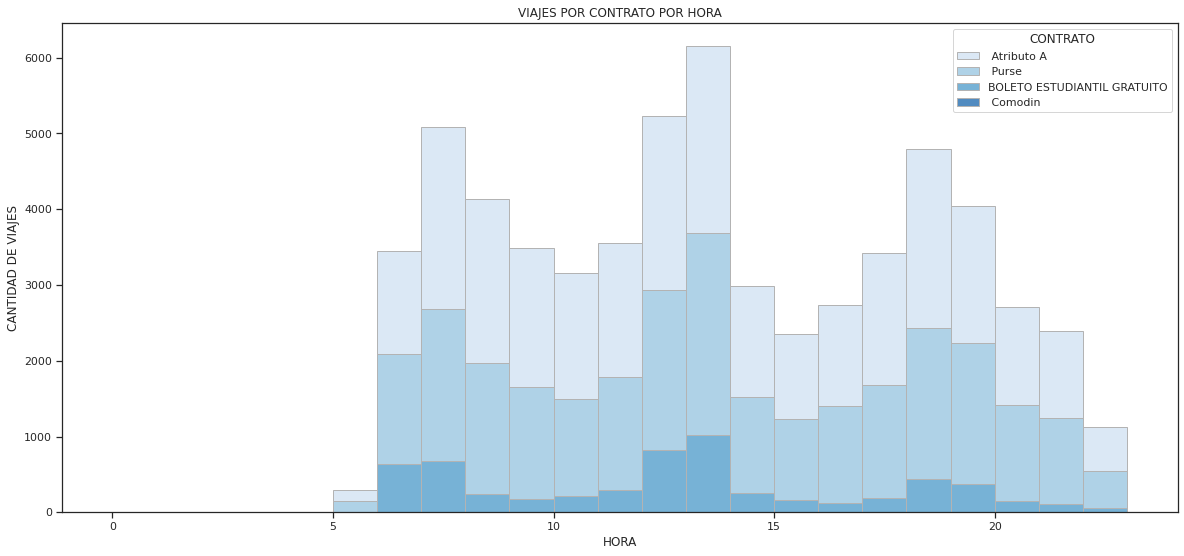

In [11]:
## Vamos a graficar la cantidad de transacciones por Contrato por Hora

sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(20, 9))

sns.histplot(
    dataframe,
    x="HORA", hue="CONTRATO",
    multiple="stack",
    palette="Blues",
    edgecolor=".7",
    binwidth=1,
    bins=24,
    )
  
ax.set(xlabel='HORA',
       ylabel='CANTIDAD DE VIAJES',
       title='VIAJES POR CONTRATO POR HORA')

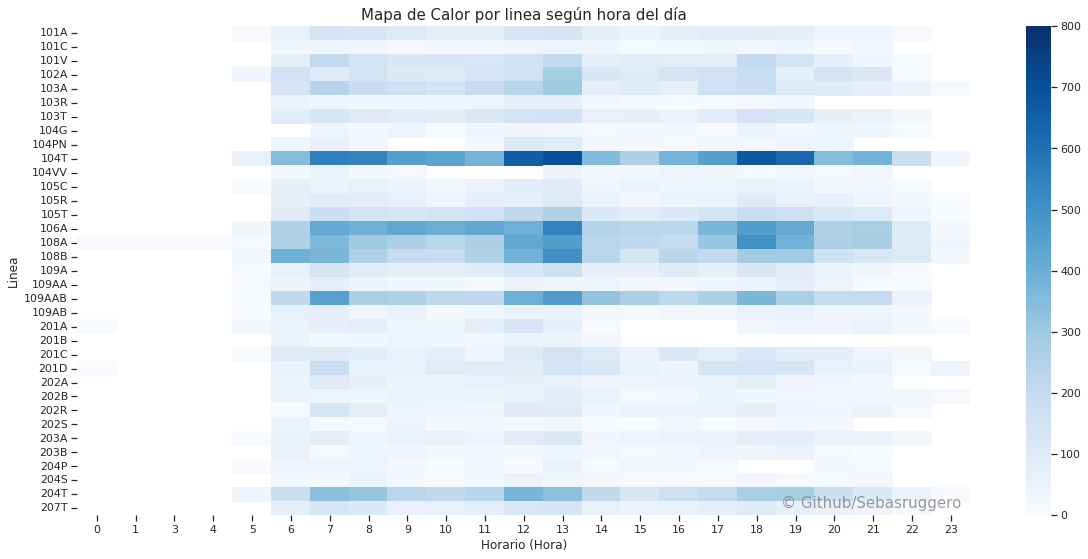

In [14]:
## Funcion para generar un heatmap con los horarios con mas actividad

def heatmap_diario(dataframe):

    # Data
    df = dataframe.copy()
    df["hour"] = pd.DatetimeIndex(df['FECHATRX']).hour
    df["linea"] = df['DESC_RAMAL']
    daily_activity = df.groupby(by=['linea','hour']).count()['FECHATRX'].unstack()

    # Armamos la figura
    fig, ax = plt.subplots(figsize=(20,9))
    sns.heatmap(daily_activity, robust=True, vmin=0, vmax=800, cmap="Blues") # "YlOrBr

    # Asignamos las etiquetas 
    plt.xlabel("Horario (Hora)", fontsize= 12, x = 0.5)
    plt.ylabel("Linea", fontsize= 12)
    plt.title("Mapa de Calor por linea según hora del día", fontsize= 15)

    # Marca Agua
    ax.text(0.99, 0.01, '© Github/Sebasruggero',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.8)   # Marca Agua

heatmap_diario(dataframe)


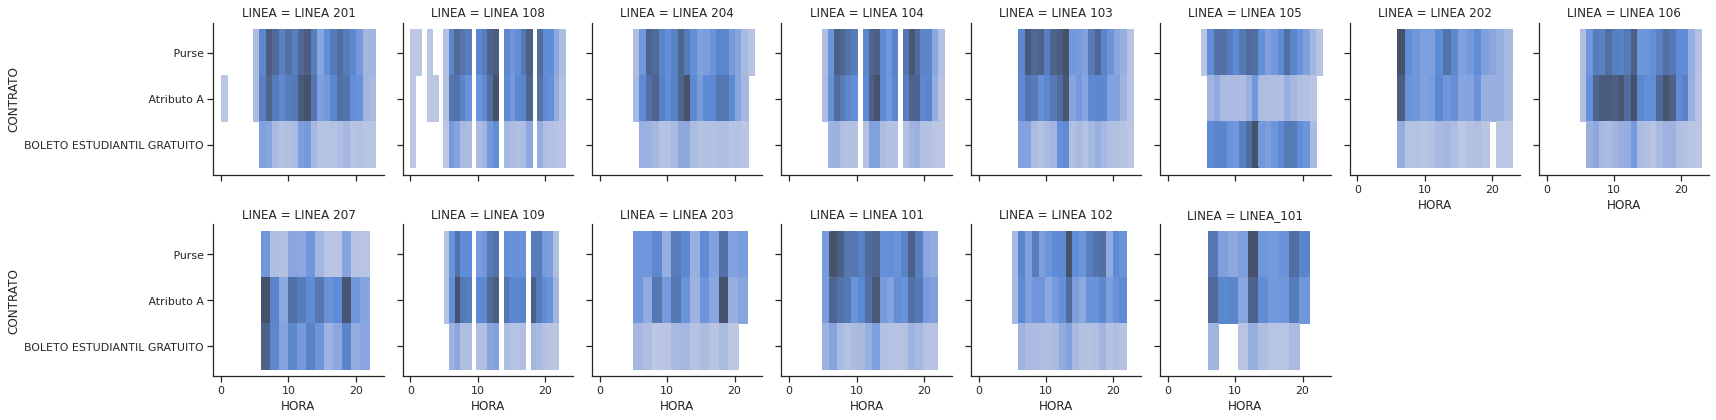

In [136]:
## Ahora vamos a graficar un mapa de calor por tipo de contrato por linea
df_filter = dataframe[dataframe.CONTRATO.isin([" Atributo A", " Purse", "BOLETO ESTUDIANTIL GRATUITO"])]
g = sns.FacetGrid(df_filter, col="LINEA", col_wrap=8)
g.map(sns.histplot, "HORA", "CONTRATO")

Text(0.99, 0.01, '© Github/Sebasruggero')

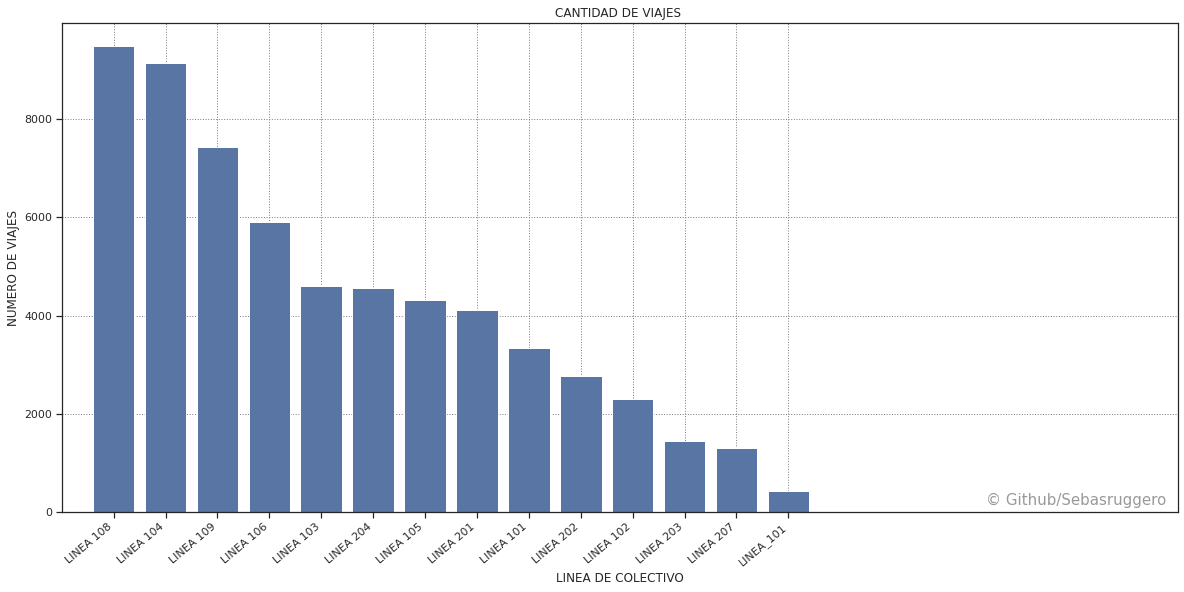

In [16]:
 #Ranking de empresas por cantidad de transacciones
# Cargamos la data
df = dataframe.copy()
df["hour"] = pd.DatetimeIndex(df['FECHATRX']).hour
df["weekday"] = pd.DatetimeIndex(df['FECHATRX']).weekday
daily_activity = df.groupby(by=['weekday','hour']).count()['FECHATRX'].unstack()

# Dibujamos 
fig = plt.figure(figsize=(20,9))
ax = sns.countplot(x="LINEA" ,color="b", data=df, order = df['LINEA'].value_counts().index)

# Etiquetamos 
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.xlabel("LINEA DE COLECTIVO", fontsize= 12, x = 0.5)
plt.ylabel("NUMERO DE VIAJES", fontsize= 12)
plt.title("CANTIDAD DE VIAJES ")
plt.xlim(-1,20.5)

# Dibujamos la grilla
plt.grid(linestyle=":", color='grey')

# Marca Agua
ax.text(0.99, 0.01, '© Github/Sebasruggero',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.8)  

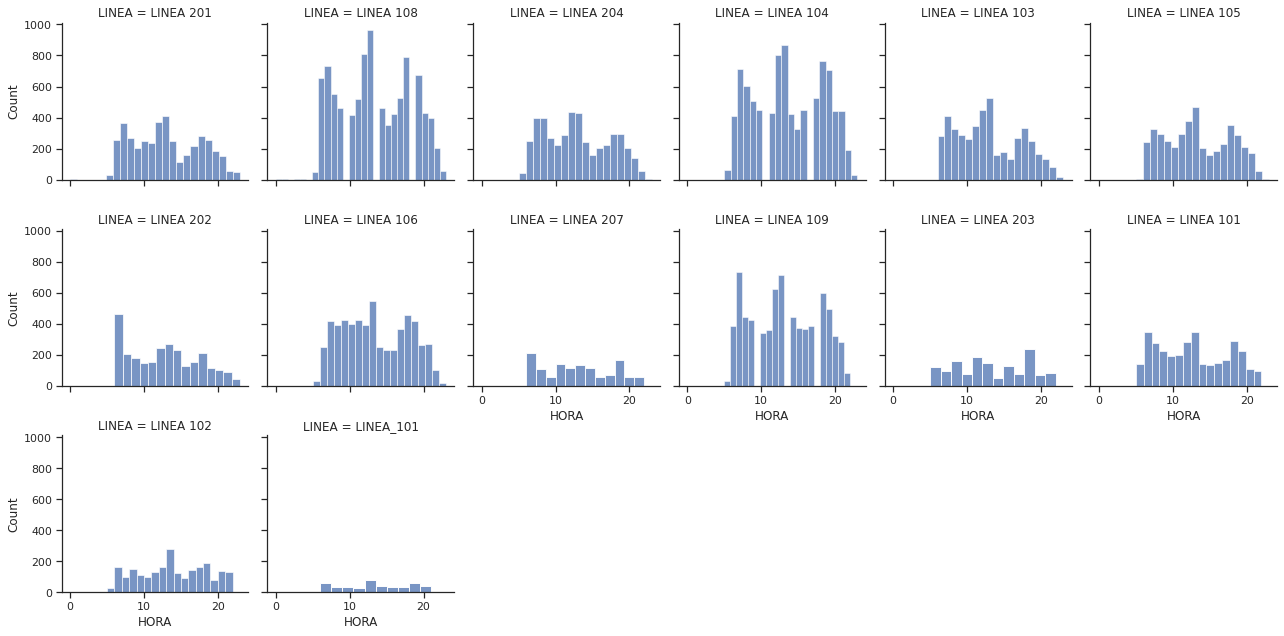

In [19]:
## Ahora vamos a ver la cantidad de transacciones abierto por linea
g = sns.FacetGrid(dataframe, col="LINEA", col_wrap=6)
g.map(sns.histplot, "HORA")

In [20]:
## Mapa Calor

## Copiamos el dataframe
df = dataframe.copy()

## Seteamos el mapa de folium
m = folium.Map(location=[-28.469581, -65.779544], tiles="OpenStreetMap",zoom_start=12)

#Filtramos las condiciones 
##heat_df =dataframe[(dataframe.DESC_RAMAL =='203B')] # Filtramos por Ramal
h_df =df[(df.CONTRATO =='BOLETO ESTUDIANTIL GRATUITO')] # Filtramos por boleto estudiantil 

## Armo la lista de pos
heat_data = [[row['LATITUDE'],row['LONGITUDE']] for index, row in h_df.iterrows()]

## Agrego la info al mapa y grafico el Mapa de Calor
HeatMap(heat_data, radius=7, blur= 5 ).add_to(m)

## Muestro el Mapa
display(m)


## Vamos a cruzar la información de las transacciones con el shape de los barrios populares del [RENABAP](https://https://www.argentina.gob.ar/desarrollosocial/renabap/mapa) para observar el acceso por parte de los habitantes a los servicios

In [22]:
## Cargamos los set de datos de datos abiertos RENABAP
url = "https://datosabiertos.desarrollosocial.gob.ar/dataset/0d022767-9390-486a-bff4-ba53b85d730e/resource/97cc7d10-ad4c-46cb-9ee4-becb402adf9f/download/20220131_info_publica.geojson"
barrios_populares = gpd.read_file(url)
barrios_populares.head(1)

##Pasamos el dataframe a Geopandas
df_gpd = gpd.GeoDataFrame(dataframe, geometry=gpd.points_from_xy(x=dataframe.LONGITUDE, y=dataframe.LATITUDE))

## Filtramos la provincia de Catamarca y la localidad que vamos a evaluar - En este caso la localidad de San Fernando del Valle de Catamarca en la Provincia de Catamarca
barrios = barrios_populares[(barrios_populares.Provincia =='Catamarca') & (barrios_populares.Localidad=='San Fernando Del Valle De Catamarca') ] # Filtramos por linea


## Superponemos ambos layer para poder vizualizar la actividad de transacciones en los barrios populares y tener un acercamiento a la cobertura del servicio.

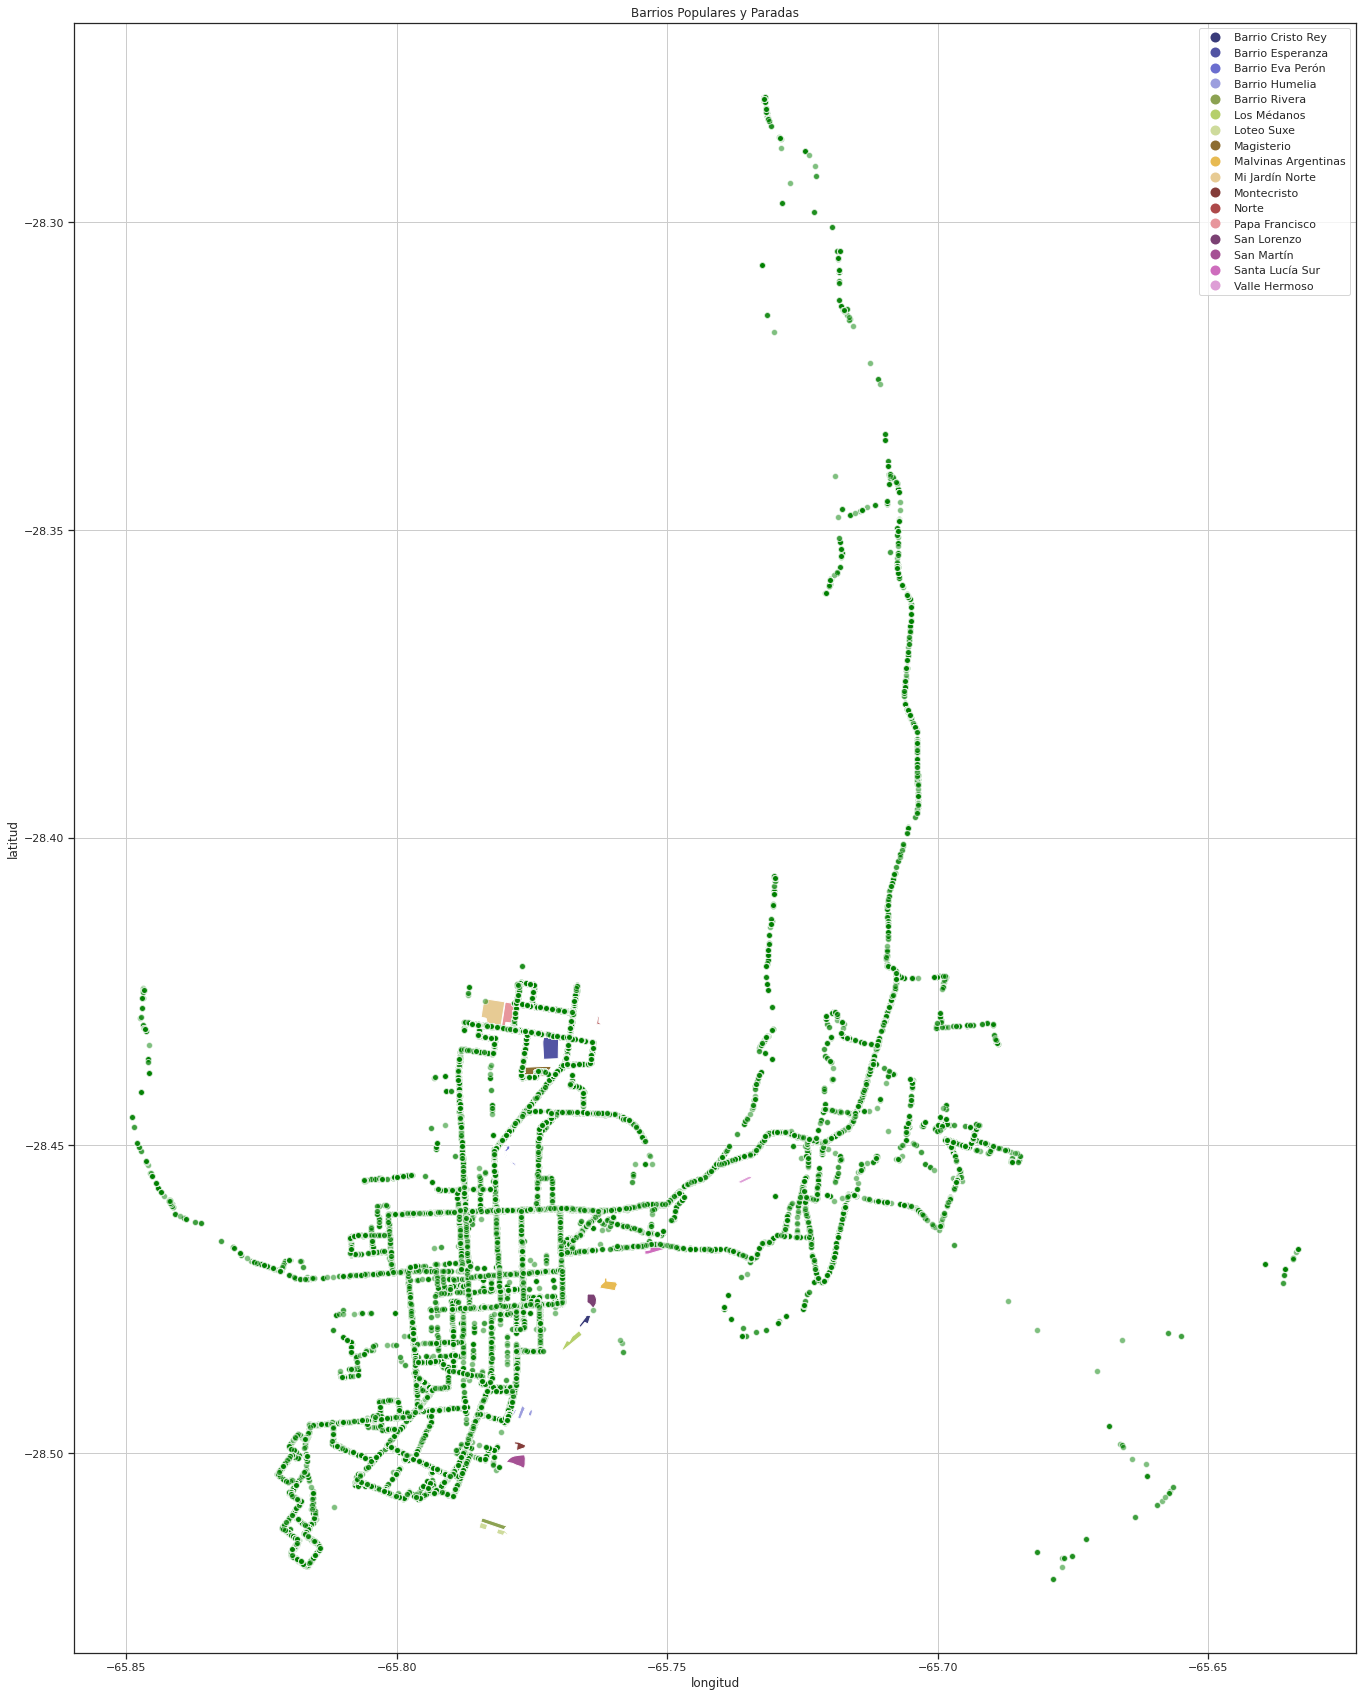

In [23]:
# Graficamos el shape junto con los recorridos para poder observar 
barrios.plot(column='Barrio', legend=True , figsize=(30,30), cmap="tab20b")

# Agregamos los puntos del recorrido
plt.scatter(x=df_gpd.LONGITUDE, y=df_gpd.LATITUDE, c='green', edgecolor = 'white', alpha=0.5)

# Agegamos etiquetas y titulos
plt.title('Barrios Populares y Paradas')
plt.xlabel('longitud')
plt.ylabel('latitud')


# Agregamos grid y mostramos
plt.grid()
plt.show()

## Ahora vamos a determinar las transacciones que se realizaron dentro de los barrio populares ( Si bien esta información no es exacta porque la validación no es in-situ, podriamos estimar la cercania de los pasajeros a estos barrios.

In [24]:
## Cramos el mapa en Folium con el Geodataser
m = folium.Map(location=[-28.469581, -65.779544], tiles="OpenStreetMap",zoom_start=12)
HeatMap(heat_data, radius=7, blur= 5 ).add_to(m)
folium.GeoJson(barrios.geometry).add_to(m)
display(m)
